In [4]:
# Amplitude Source Location
import os
import sys
import time
import obspy
from obspy.clients.filesystem.sds import Client as sdsclient
from obspy.core.inventory.inventory import read_inventory
sys.path.append("..")
sys.path.append("../lib")
import setup_paths
paths = setup_paths.paths
from SAM import DSAM
import InventoryTools
import SDS

#####################################################################################

mySDSreadClient = sdsclient(paths['SDS_DIR'])
#mySDSwriteClient = SDS.SDSobj(SDS_DIR2, sds_type='D', format='MSEED')

startTime = obspy.core.UTCDateTime(2001,2,25,0,0,0)
endTime = obspy.core.UTCDateTime(2001,3,6,0,0,0)
secondsPerDay = 60 * 60 * 24
numDays = (endTime-startTime)/secondsPerDay
invMVO = read_inventory(os.path.join(paths['RESPONSE_DIR'],'MV.xml'), format='stationxml')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/thompsong/work/PROJECTS/MESS2024_Glenn/data/responses/MV.xml'

In [ ]:
invMVO.plot(projection='local', resolution='f');

In [31]:
import numpy as np
import math
import matplotlib.pyplot as plt
class Grid:
    def __init__(self, centerlat, centerlon, nlat, nlon, node_spacing_m):
        deg2m = 111100
        node_spacing_lat = node_spacing_m / deg2m
        minlat = centerlat - (nlat-1)/2 * node_spacing_lat
        maxlat = centerlat + (nlat-1)/2 * node_spacing_lat
        latrange = np.arange(minlat, maxlat, node_spacing_lat)
        node_spacing_lon = node_spacing_lat / np.cos(centerlat / (2 * math.pi))
        minlon = centerlon - (nlon-1)/2 * node_spacing_lon
        maxlon = centerlon + (nlon+1)/2 * node_spacing_lon
        lonrange = np.arange(minlon, maxlon, node_spacing_lon)
        gridlon, gridlat = np.meshgrid(lonrange, latrange)
        self.gridlon = gridlon
        self.gridlat = gridlat
        self.node_spacing_lat = node_spacing_lat
        self.node_spacing_lon = node_spacing_lon
        self.lonrange = lonrange
        self.latrange = latrange

    def plot(self):
        plt.plot(self.gridlon, self.gridlat, marker='+', color='k', linestyle='none')
        plt.show()


class ASL:
    def __init__(self, samobject, metric, inventory, gridobj):
        ''' 
        ASL: Simple amplitude-based source location for volcano-seismic data 
        This program takes a VSAM, VSEM, or DSAM object as input
        Then armed with an inventory that provides station coordinates, it attempts
        to find a location for each sample by reducing amplitudes based on the grid
        node to station distance. Grid nodes are contained in a Grid object.

        ASL can use any one of the mean, max, median, VLP, LP, or VT metrics from a VSAM or DSAM object,
        or the energy metric from a VSEM object.

        '''

        if isinstance(samobject, VSAM) or isinstance(samobject, DSAM):
            datatype = 'amplitude'
        elif isinstance(samobject, VSEM):
            datatype = 'energy'
        else:
            print('invalid type passed as samobject. Aborting')
            return

        self.samobject = samobject
        self.metric = metric
        self.inventory = inventory
        self.gridobj = gridobj
        self.node_distances_km = {}
        self.station_coordinates = {}
        self.amplitude_corrections = {}

    def setup(self, surfaceWaves=False):  
        self.compute_grid_distances()
        self.compute_amplitude_corrections(surfaceWaves = surfaceWaves)

    def compute_grid_distances(self):
        st = self.samobject.to_stream()
        coordinates = {}
        node_distances_m = {}
        for tr in st:
            try:
                coordinates[tr.id] = self.inventory.get_coordinates(tr.id)
            except Exception as e:
                print(e)
                continue
            node_distances_m[tr.id], _, _ = gps2dist_azimuth(self.gridobj.gridlat, self.gridobj.gridlon, coordinates[tr.id]['latitude'], coordinates[tr.id]['longitude'])
        self.node_distances_km = node_distances_m/1000
        self.station_coordinates = coordinates 

    def compute_amplitude_corrections(self, surfaceWaves=False):
        #st = self.samobject.to_stream()
        if surfaceWaves:
            wavespeed_kms = 2
        else:
            wavespeed_kms = 3
        
        for seed_id, df in self.samobject.dataframes.items():
            if self.metric in ['mean', 'median', 'max', 'energy']:
                ratio = df['VT'].sum()/df['LP'].sum()
                peakf = np.sqrt(ratio) * 4
            elif self.metric == 'VLP':
                peakf = 0.1
            elif self.metric == 'LP':
                peakf = 2.0
            elif self.metric == 'VT':
                peakf = 8.0
            wavelength_km = peakf * wavespeed_kms
            if surfaceWaves and seed_id[-2]=='H':
                gsc = np.sqrt(node_distances_km[seed_id] * wavelength_km)
            else:
                gsc = node_distances_km
            if Q:
                t = node_distances_km / wavespeed_kms
                iac = np.power(math.e, math.pi * peakf * t * Q)
                corrections[seed_id] = np.multiply(gsc, iac)
            else:
                corrections[seed_id] = gsc
        self.amplitude_corrections = corrections
            
            
    
    def locate(self):
        st = self.samobject.to_stream(metric=self.metric)
        seed_ids = [tr.id for tr in st]
        lendata = len(st[0].data)
        lencorrections = len(self.amplitude_corrections[st[0].id])
        t = st[0].times('utcdatetime')
        for i in range(lendata): # loop ovder time samples
            y = [tr.data[i] for tr in st] # (len(st), 1)
            reduced_y = []
            misfit = []
            best_j = -1
            best_misfit = 1e10
            for j in range(lencorrections): # loop over nodes
                # assume source is at grid node j
                c = [self.amplitude.corrections[id][j] for id in seed_ids] # corrections for this node (len(st), 1)
                if self.metric=='energy':
                    c = np.multiply(c,c)
                reduced_y = np.multiply(y, c) # correcting everything to 1 km distance for all seed ids
                this_misfit = np.nanstd(reduced_y)/np.nanmedian(reduced_y)
                if this_misfit < best_misfit:
                    best_misfit = this_misfit
                    best_j = j
                misfit.append(this_misfit)
            print(f"time: {t[i]}: best misfit = {best_misfit} at node {best_j} corresponding to {self.lonrange}, {self.latrange}")        
            # Here is where i would add loop over shrinking grid
        
            
from SAM import VSAM, VSEM, DSAM       
source = {'lat':16.71111, 'lon':-62.17722}
nlat = 21
nlon = 11
node_spacing_m = 100
gridobj = Grid(source['lat'], source['lon'], nlat, nlon, node_spacing_m)  
invMVO = None # SCAFFOLD
vsamobj = None # SCAFFOLD
aslobj = ASL(vsamobj, 'median', invMVO, gridobj)        

invalid type passed as samobject. Aborting


{'gridlat': array([[16.7021091 , 16.7021091 , 16.7021091 , 16.7021091 , 16.7021091 ,
        16.7021091 , 16.7021091 , 16.7021091 , 16.7021091 , 16.7021091 ,
        16.7021091 ],
       [16.70300919, 16.70300919, 16.70300919, 16.70300919, 16.70300919,
        16.70300919, 16.70300919, 16.70300919, 16.70300919, 16.70300919,
        16.70300919],
       [16.70390928, 16.70390928, 16.70390928, 16.70390928, 16.70390928,
        16.70390928, 16.70390928, 16.70390928, 16.70390928, 16.70390928,
        16.70390928],
       [16.70480937, 16.70480937, 16.70480937, 16.70480937, 16.70480937,
        16.70480937, 16.70480937, 16.70480937, 16.70480937, 16.70480937,
        16.70480937],
       [16.70570946, 16.70570946, 16.70570946, 16.70570946, 16.70570946,
        16.70570946, 16.70570946, 16.70570946, 16.70570946, 16.70570946,
        16.70570946],
       [16.70660955, 16.70660955, 16.70660955, 16.70660955, 16.70660955,
        16.70660955, 16.70660955, 16.70660955, 16.70660955, 16.70660955,
  

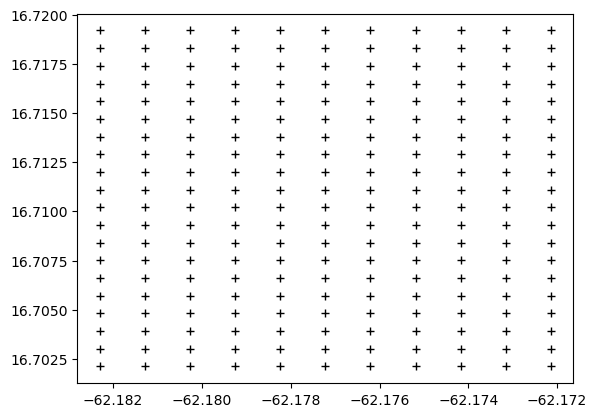

In [15]:
import pprint
pprint.pprint(vars(gridobj))
gridobj.plot()

In [25]:
a = np.array([[1, 2, 3, 4],])
b= np.array([10, 100, 1000, 0])
print(a * b.transpose())

[[  10  200 3000    0]]
